## Step 1: Install Required Libraries (Colab Only)
Before we begin, we check if we're in Google Colab. If so, we install all necessary Python libraries required for PDF processing and text analysis.


In [ ]:
import os as operating_sys

def check_and_install():
    if "COLAB_GPU" in operating_sys.environ:
        print("[SETUP] Detected Google Colab environment. Installing necessary libraries...")
        required_packages = [
            "torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0",
            "PyMuPDF",
            "tqdm",
            "sentence-transformers",
            "accelerate",
            "bitsandbytes"
        ]
        for package in required_packages:
            !pip install {package}
        # Note: Skipping flash-attn due to known compatibility limitations in Colab

check_and_install()


[SETUP] Detected Google Colab environment. Installing necessary libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

## Step 2: Download the PDF File
Now we check whether the textbook PDF is already available locally. If not, we download it from an open educational resources site.


In [ ]:
import os as operating_sys
import requests as http_client

# Define file and source URL
document_name = "human-nutrition-text.pdf"
source_link = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

def fetch_pdf_if_missing(file_path, download_url):
    if not operating_sys.path.isfile(file_path):
        print("PDF not found locally. Starting download...")
        response_data = http_client.get(download_url)

        if response_data.status_code == 200:
            with open(file_path, "wb") as output_file:
                output_file.write(response_data.content)
            print(f"Download complete. Saved as '{file_path}'.")
        else:
            print(f"Unable to retrieve the file. HTTP Code: {response_data.status_code}")
    else:
        print(f"PDF already exists at: {file_path}")

fetch_pdf_if_missing(document_name, source_link)


PDF not found locally. Starting download...
Download complete. Saved as 'human-nutrition-text.pdf'.


If the file doesn't exist, you'll see a message that it's downloading, followed by confirmation that it has been saved. If it's already there, you'll see a message stating that.



## Step 3: Extract Text Content from the PDF
Next, we use the PyMuPDF library to go through each page of the PDF and extract plain text. We also calculate statistics like word count, estimated sentences, and token count.



In [ ]:
import fitz as pymupdf_lib  # PyMuPDF library
from tqdm.auto import tqdm as progress_bar  # Progress bar utility

def format_text_simple(raw_text: str) -> str:
    """
    Applies basic formatting to the extracted text content.
    """
    return raw_text.replace("\n", " ").strip()

def extract_pdf_content(file_location: str) -> list[dict]:
    """
    Reads the PDF file from the provided path, processes each page,
    and returns structured content with basic text statistics.

    Args:
        file_location (str): Path to the target PDF file.

    Returns:
        list[dict]: Information per page including adjusted page number,
                    character count, word count, sentence count estimate, token count estimate, and raw text.
    """
    pdf_file = pymupdf_lib.open(file_location)
    extracted_data = []

    for idx, pg in progress_bar(enumerate(pdf_file)):
        raw_text = pg.get_text()
        cleaned = format_text_simple(raw_text)
        page_info = {
            "adjusted_page_id": idx - 41,  # our document starts from page 42
            "char_count": len(cleaned),
            "word_count": len(cleaned.split()),
            "estimated_sentences": len(cleaned.split(". ")),
            "estimated_tokens": len(cleaned) / 4,
            "content": cleaned
        }
        extracted_data.append(page_info)

    return extracted_data

pdf_analysis = extract_pdf_content(file_location=document_name)
pdf_analysis[:2]


0it [00:00, ?it/s]

[{'adjusted_page_id': -41,
  'char_count': 29,
  'word_count': 4,
  'estimated_sentences': 1,
  'estimated_tokens': 7.25,
  'content': 'Human Nutrition: 2020 Edition'},
 {'adjusted_page_id': -40,
  'char_count': 0,
  'word_count': 0,
  'estimated_sentences': 1,
  'estimated_tokens': 0.0,
  'content': ''}]

You’ll get a preview of the extracted text and stats for the first two pages (starting from logical page 1, which maps to page 42 of the PDF).


## Step 4: Select Random Sample Pages
To explore the extracted data easily, we randomly select a few pages. This helps us check whether the extraction worked well.



In [ ]:
import random as rnd

def select_random_pages(data_collection: list, count: int = 3) -> list:
    """
    Picks a random subset of page data entries.

    Args:
        data_collection (list): The complete list of page-level dictionaries.
        count (int): Number of entries to randomly pick.

    Returns:
        list: A list of randomly selected entries.
    """
    return rnd.sample(data_collection, k=count)

select_random_pages(pdf_analysis, count=3)


[{'adjusted_page_id': 779,
  'char_count': 276,
  'word_count': 49,
  'estimated_sentences': 1,
  'estimated_tokens': 69.0,
  'content': 'Image by Pua  O Eleili Pinto  / CC BY 4.0  Introduction  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  I maika‘i ke kalo i ka ‘ohā  The goodness of the taro is judged by the young plant it  produces  Introduction  |  779'},
 {'adjusted_page_id': 231,
  'char_count': 1425,
  'word_count': 206,
  'estimated_sentences': 16,
  'estimated_tokens': 356.25,
  'content': 'Carbohydrat es are broken  down into  the  subgroups  simple and  complex  carbohydrate s. These  subgroups  are further  categorized  into mono-,  di-, and  polysacchari des.  indigestible carbohydrates provide a good amount of fiber with a  host of other health benefits.  Plants synthesize the fast-releasing carbohydrate, glucose, from  carbon dioxide in the air and water, and by harnessing the sun’s  energy. Recall that plants conve

This will return a list of 3 random page entries with their content and statistics. Useful for quick verification.



## Step 5: Convert Data into a Pandas DataFrame
We convert the full list of extracted data into a DataFrame. This makes it easier to view, filter, and analyze the information using Pandas.



In [ ]:
import pandas as pd

# Convert extracted PDF data into a DataFrame
page_dataframe = pd.DataFrame(pdf_analysis)

# Preview the first few rows
page_dataframe.head()


,adjusted_page_id,char_count,word_count,estimated_sentences,estimated_tokens,content
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,0,1,0.00,
2,-39,320,42,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,30,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,116,2,199.25,Contents Preface University of Hawai‘i at Mā...


You’ll see a table (DataFrame) showing the first few rows of processed PDF pages with fields like `adjusted_page_id`, `char_count`, `word_count`, and the `content`.



## Step 6: Get Summary Statistics of PDF Content
We use the `describe()` method in Pandas to compute statistical summaries of the extracted data — like min, max, mean, and standard deviation for word count, token count, etc.


In [ ]:
# Generate basic statistical summary of the DataFrame
summary_stats = page_dataframe.describe().round(2)
summary_stats


,adjusted_page_id,char_count,word_count,estimated_sentences,estimated_tokens
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,171.97,9.97,287.00
std,348.86,560.38,86.49,6.19,140.10
min,-41.00,0.00,0.00,1.00,0.00
25%,260.75,762.00,109.00,4.00,190.50
50%,562.50,1231.50,183.00,10.00,307.88
75%,864.25,1603.50,239.00,14.00,400.88
max,1166.00,2308.00,393.00,32.00,577.00


The output shows summary stats for all numeric columns. This helps understand the overall scale and variation in the extracted data.



## Step 7: Initialize Sentence Segmenter
We now prepare the NLP pipeline using spaCy to split text into sentences. This is important to later chunk the data intelligently.



In [ ]:
from spacy.lang.en import English as SpacyEnglish  # Language model

# Initialize a blank English NLP pipeline
language_processor = SpacyEnglish()

# Add sentence segmentation component
language_processor.add_pipe("sentencizer")

# Example usage to validate sentence splitting
sample_text = "This is a sentence. This another sentence."
processed_doc = language_processor(sample_text)

# Assertion to verify segmentation
assert len(list(processed_doc.sents)) == 2

# Output list of identified sentences
list(processed_doc.sents)


[This is a sentence., This another sentence.]

The spaCy pipeline is initialized. There’s no output, but sentence segmentation will work on the next run.



## Step 8: Segment Text into Sentences
We apply the NLP pipeline to every page's text content, splitting the text into individual sentences and storing them.



In [ ]:
for entry in progress_bar(pdf_analysis):
    # Apply sentence segmentation
    entry["segmented_sentences"] = list(language_processor(entry["content"]).sents)

    # Ensure sentence objects are converted to strings
    entry["segmented_sentences"] = [str(sent) for sent in entry["segmented_sentences"]]

    # Store the sentence count based on spaCy processing
    entry["sentence_count_spacy"] = len(entry["segmented_sentences"])


  0%|          | 0/1208 [00:00<?, ?it/s]

There is no visual output here, but each entry in the dataset now contains a list of segmented sentences.


## Step 9: Preview Segmented Sentences
We randomly display one processed entry with its segmented sentences to ensure the segmentation worked properly.



In [ ]:
# View a random page entry with segmented sentences
select_random_pages(pdf_analysis, count=1)


[{'adjusted_page_id': 1113,
  'char_count': 1619,
  'word_count': 227,
  'estimated_sentences': 17,
  'estimated_tokens': 404.75,
  'content': 'not others. The Diabetes Prevention Trial that studied lifestyle and  drug interventions in more than three thousand participants who  were at high risk for Type 2 diabetes found that intensive lifestyle  intervention reduced the chances of getting Type 2 diabetes by 58  percent.11  Gestational Diabetes  During pregnancy some women develop gestational diabetes.  Gestational diabetes is characterized by high blood-glucose levels  and insulin resistance. The exact cause is not known but does  involve the effects of pregnancy hormones on how cells respond  to insulin. Gestational diabetes can cause pregnancy complications  and it is common practice for healthcare practitioners to screen  pregnant women for this metabolic disorder. The disorder normally  ceases when the pregnancy is over, but the National Diabetes  Information Clearing House notes 

This shows one random page with its list of sentences. It confirms sentence splitting was successful.


## Step 10: Refresh DataFrame With Sentences
We refresh the DataFrame so it now includes the segmented sentence lists. We also display updated summary stats.


In [ ]:
# Refresh DataFrame with updated data including sentence segmentation
page_dataframe = pd.DataFrame(pdf_analysis)

# Display statistical summary
page_dataframe.describe().round(2)


,adjusted_page_id,char_count,word_count,estimated_sentences,estimated_tokens,sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,171.97,9.97,287.00,10.32
std,348.86,560.38,86.49,6.19,140.10,6.30
min,-41.00,0.00,0.00,1.00,0.00,0.00
25%,260.75,762.00,109.00,4.00,190.50,5.00
50%,562.50,1231.50,183.00,10.00,307.88,10.00
75%,864.25,1603.50,239.00,14.00,400.88,15.00
max,1166.00,2308.00,393.00,32.00,577.00,28.00


The output is similar to earlier summary stats but now reflects sentence-based data as well.


## Step 11: Chunk Sentences into Groups
We now define a function to group sentences into chunks of a fixed size (e.g., 10 sentences). This is useful for embedding and search later.


In [ ]:
# Define how many sentences per chunk
chunk_size_sentences = 10

def divide_into_chunks(seq: list, chunk_len: int) -> list[list[str]]:
    """
    Divides a list into smaller sublists of specified length.

    Example: 17 items with chunk_len=10 → [[10 items], [7 items]]
    """
    return [seq[start:start + chunk_len] for start in range(0, len(seq), chunk_len)]

# Apply chunking to each document entry
for entry in progress_bar(pdf_analysis):
    entry["sentence_groups"] = divide_into_chunks(seq=entry["segmented_sentences"],
                                                  chunk_len=chunk_size_sentences)
    entry["total_chunks"] = len(entry["sentence_groups"])


  0%|          | 0/1208 [00:00<?, ?it/s]

This defines the chunking logic. No output yet, but the function will be used in the next few steps to organize the content.


## Step 12: Preview a Chunked Entry
We randomly select one page and view its sentence chunks. This helps us verify the chunking logic visually.


In [ ]:
# Randomly inspect one entry with its sentence chunks
select_random_pages(pdf_analysis, count=1)


[{'adjusted_page_id': 401,
  'char_count': 1668,
  'word_count': 224,
  'estimated_sentences': 20,
  'estimated_tokens': 417.0,
  'content': 'how proteins, specifically those in red and processed meats, causes  colon cancer is not known and requires further study.  Some scientists hypothesize that high-protein diets may  accelerate bone-tissue loss because under some conditions the  acids in protein block absorption of calcium in the gut, and, once  in the blood, amino acids promote calcium loss from bone; however  even these effects have not been consistently observed in scientific  studies. Results from the Nurses’ Health Study suggest that women  who eat more than 95 grams of protein each day have a 20 percent  higher risk for wrist fracture.23  Other studies have not produced consistent results. The scientific  data on high protein diets and increased risk for osteoporosis  remains highly controversial and more research is needed to come  to any conclusions about the association be

You’ll see one random page’s sentence chunks, confirming how the data is being grouped for later analysis.



## Step 13: Update DataFrame With Chunked Sentences
We refresh the Pandas DataFrame again to include the new sentence group (chunk) data and compute updated statistics.


In [ ]:
# Recreate the DataFrame with the latest chunking information
page_dataframe = pd.DataFrame(pdf_analysis)

# Display updated statistics
page_dataframe.describe().round(2)


,adjusted_page_id,char_count,word_count,estimated_sentences,estimated_tokens,sentence_count_spacy,total_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,171.97,9.97,287.00,10.32,1.53
std,348.86,560.38,86.49,6.19,140.10,6.30,0.64
min,-41.00,0.00,0.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,109.00,4.00,190.50,5.00,1.00
50%,562.50,1231.50,183.00,10.00,307.88,10.00,1.00
75%,864.25,1603.50,239.00,14.00,400.88,15.00,2.00
max,1166.00,2308.00,393.00,32.00,577.00,28.00,3.00


The output provides updated summary statistics that now reflect chunk-level data.


## Step 14: Flatten All Sentence Chunks
We now flatten the nested structure so each row represents a single sentence chunk. This format is ideal for embedding and retrieval tasks.


In [ ]:
import re as regex_tool

# Flatten chunks into individual records
flattened_chunks = []

for record in progress_bar(pdf_analysis):
    for group in record["sentence_groups"]:
        chunk_entry = {}

        # Preserve page reference
        chunk_entry["adjusted_page_id"] = record["adjusted_page_id"]

        # Merge sentences into a single chunked string
        merged_chunk = "".join(group).replace("  ", " ").strip()
        merged_chunk = regex_tool.sub(r'\.([A-Z])', r'. \1', merged_chunk)  # Add space after period if followed by uppercase

        chunk_entry["text_chunk"] = merged_chunk

        # Add metadata about the chunk
        chunk_entry["char_count"] = len(merged_chunk)
        chunk_entry["word_count"] = len(merged_chunk.split())
        chunk_entry["token_estimate"] = len(merged_chunk) / 4  # Rough token estimation

        flattened_chunks.append(chunk_entry)

# Report the total number of chunks
len(flattened_chunks)


  0%|          | 0/1208 [00:00<?, ?it/s]

1843

This code populates a new list (`flattened_chunks`) where each entry is a single text chunk with its metadata.


## Step 15: Preview Flattened Chunk
We view one randomly selected text chunk from the flattened list to ensure the format is correct.


In [ ]:
# Randomly preview one chunked text entry
select_random_pages(flattened_chunks, count=1)


[{'adjusted_page_id': 691,
  'text_chunk': 'features interactive learning activities.\xa0 These activities are available in the web-based textbook and not available in the downloadable versions (EPUB, Digital PDF, Print_PDF, or Open Document). Learning activities may be used across various mobile devices, however, for the best user experience it is strongly recommended that users complete these activities using a desktop or laptop computer and in Google Chrome. \xa0 An interactive or media element has been excluded from this version of the text. You can view it online here: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=397 \xa0 Manganese | 691',
  'char_count': 605,
  'word_count': 85,
  'token_estimate': 151.25}]

You will see one chunk entry that includes the grouped text and metadata like token count.


## Step 16: Create DataFrame of All Text Chunks
We convert the flattened list of sentence chunks into a new Pandas DataFrame for embedding and filtering.


In [ ]:
# Create a DataFrame from the flattened chunk list
chunk_dataframe = pd.DataFrame(flattened_chunks)

# Display summary statistics of the chunk data
chunk_dataframe.describe().round(2)


,adjusted_page_id,char_count,word_count,token_estimate
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.44,112.56,183.61
std,347.79,447.54,71.26,111.89
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,746.00,115.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


This outputs summary statistics of the new DataFrame, giving insights into the size and distribution of text chunks.


## Step 17: View Short Chunks
We filter the dataset to find chunks with fewer than a certain number of tokens (e.g., ≤ 30), then preview some samples.


In [ ]:
# Define the minimum token threshold
token_threshold = 30

# Filter and sample short chunks, then print them
short_chunks = chunk_dataframe[chunk_dataframe["token_estimate"] <= token_threshold].sample(5)

for _, row in short_chunks.iterrows():
    print(f"Token estimate: {row['token_estimate']} | Text: {row['text_chunk']}")


Token estimate: 25.25 | Text: The Polynesian Family System in Ka-‘u. Rutland, Vermont: Charles E. Tuttle Company 780 | Introduction
Token estimate: 24.5 | Text: view it online here: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=354 Phytochemicals | 605
Token estimate: 13.0 | Text: PART VII CHAPTER 7. ALCOHOL Chapter 7. Alcohol | 429
Token estimate: 28.0 | Text: Fluid balance refers to maintaining the distribution of water in the body. 386 | Protein’s Functions in the Body
Token estimate: 10.5 | Text: 442 | Health Consequences of Alcohol Abuse


You’ll see a few short text chunks, which can be filtered out later as they may not be useful for embedding.


## Step 18: Keep Only Long Chunks
We filter the dataset again to keep only chunks above the token threshold. These will be passed to the embedding model.


In [ ]:
# Filter out chunks that exceed the token threshold
filtered_chunks = chunk_dataframe[chunk_dataframe["token_estimate"] > token_threshold].to_dict(orient="records")

# Preview the first two entries
filtered_chunks[:2]


[{'adjusted_page_id': -39,
  'text_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'char_count': 308,
  'word_count': 42,
  'token_estimate': 77.0},
 {'adjusted_page_id': -38,
  'text_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'char_count': 210,
  'word_count': 30,
  'token_estimate': 52.5}]

You’ll see a preview of the filtered chunk list, which now only contains longer, more meaningful chunks of text.


## Step 19: Load Sentence Embedding Model
We now load the `all-mpnet-base-v2` model from Sentence Transformers. This will be used to convert our text chunks into embeddings.


In [ ]:
from sentence_transformers import SentenceTransformer

# Load the sentence embedding model onto the specified device
text_embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cpu")

# Example sentences to encode
sample_sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Generate embeddings using the model
encoded_vectors = text_embedding_model.encode(sample_sentences)
sentence_to_vector_map = dict(zip(sample_sentences, encoded_vectors))

# Display results
for original_sentence, vector in sentence_to_vector_map.items():
    print("Sentence:", original_sentence)
    print("Embedding:", vector)
    print()


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07981113e-02  3.03165037e-02 -2.01217793e-02  6.86483830e-02
 -2.55255643e-02 -8.47689249e-03 -2.07147663e-04 -6.32377118e-02
  2.81606149e-02 -3.33353840e-02  3.02634649e-02  5.30720763e-02
 -5.03526479e-02  2.62288153e-02  3.33314016e-02 -4.51578461e-02
  3.63043845e-02 -1.37116178e-03 -1.20171569e-02  1.14946812e-02
  5.04510887e-02  4.70857173e-02  2.11912915e-02  5.14607765e-02
 -2.03746371e-02 -3.58889103e-02 -6.67888962e-04 -2.94393133e-02
  4.95858490e-02 -1.05639603e-02 -1.52013749e-02 -1.31754903e-03
  4.48196754e-02  1.56023391e-02  8.60379942e-07 -1.21397164e-03
 -2.37978995e-02 -9.09372000e-04  7.34479493e-03 -2.53932923e-03
  5.23370057e-02 -4.68043573e-02  1.66214500e-02  4.71579209e-02
 -4.15599570e-02  9.01942665e-04  3.60278897e-02  3.42214778e-02
  9.68227163e-02  5.94828576e-02 -1.64984670e-02 -3.51250097e-02
  5.92516316e-03 -7.07960629e-04 -2.4103

The model is loaded and ready to encode text into dense vector representations. No output is shown unless there's an error.


## Step 20: Try Sample Embedding
We test the embedding model on a short sentence to verify that it works and to inspect the vector dimensions.


In [ ]:
test_sentence = "Yo! How cool are embeddings?"
test_vector = text_embedding_model.encode(test_sentence)

print(f"Sentence: {test_sentence}")
print(f"Embedding:\n{test_vector}")
print(f"Embedding dimensions: {test_vector.shape}")


Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97447427e-02 -4.51086881e-03 -4.98485053e-03  6.55445009e-02
 -9.87679232e-03  2.72835400e-02  3.66426297e-02 -3.30218766e-03
  8.50079488e-03  8.24953429e-03 -2.28496902e-02  4.02430221e-02
 -5.75200692e-02  6.33693114e-02  4.43207026e-02 -4.49507199e-02
  1.25284074e-02 -2.52012592e-02 -3.55292559e-02  1.29559208e-02
  8.67017172e-03 -1.92917418e-02  3.55633581e-03  1.89505871e-02
 -1.47128394e-02 -9.39850323e-03  7.64166377e-03  9.62190889e-03
 -5.98926842e-03 -3.90170179e-02 -5.47824502e-02 -5.67451864e-03
  1.11644585e-02  4.08067852e-02  1.76319122e-06  9.15295724e-03
 -8.77268612e-03  2.39383057e-02 -2.32784506e-02  8.04999471e-02
  3.19177508e-02  5.12592029e-03 -1.47708794e-02 -1.62525047e-02
 -6.03212789e-02 -4.35689688e-02  4.51210849e-02 -1.79053862e-02
  2.63366923e-02 -3.47867236e-02 -8.89174361e-03 -5.47675230e-02
 -1.24372840e-02 -2.38606390e-02  8.33497047e-02  5.71242571e-02
  1.13328639e-02 -1.49595207e-02  9.2037

The printed output shows the original sentence, the embedding vector, and its dimensionality (typically 768).


## Step 21: Use GPU for Faster Embedding
To improve performance, we move the embedding model to GPU and start encoding each filtered text chunk into embeddings.


In [ ]:
%%time

# Move the embedding model to GPU (if available)
text_embedding_model.to("cuda")  # Ensure your environment has GPU support

# Generate embeddings using GPU for better performance
for chunk in progress_bar(filtered_chunks):
    chunk["embedding"] = text_embedding_model.encode(chunk["text_chunk"])


  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 31.9 s, sys: 572 ms, total: 32.5 s
Wall time: 34.2 s


This step doesn't produce visible output but generates embeddings and stores them in the original chunk records.


## Step 22: Prepare All Text Chunks for Batch Embedding
We extract all text chunks from the filtered list to prepare them for efficient, batched embedding.


In [ ]:
# Extract all text chunks from the filtered dataset
chunk_texts = [chunk["text_chunk"] for chunk in filtered_chunks]


No visible output — this just creates a list (`chunk_texts`) of all the chunk content to be passed into the model.


## Step 23: Generate Embeddings in Batches
We use the embedding model to encode all text chunks in batches, improving memory efficiency and speed.


In [ ]:
%%time

# Generate embeddings in batches for efficiency
batch_embeddings = text_embedding_model.encode(
    chunk_texts,
    batch_size=32,              # Adjust batch size for optimal performance
    convert_to_tensor=True      # Return embeddings as PyTorch tensors
)

batch_embeddings


CPU times: user 22.9 s, sys: 63.8 ms, total: 23 s
Wall time: 22.4 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

This shows how long it took to generate embeddings for all chunks. Each chunk now has a corresponding dense vector.


## Step 24: Save Chunk Embeddings to CSV
We convert the filtered chunks into a DataFrame and save it as a CSV file for reuse without reprocessing.


In [ ]:
# Convert filtered chunks with embeddings into a DataFrame
embedding_dataframe = pd.DataFrame(filtered_chunks)

# Define output file path
output_csv_path = "text_chunks_and_embeddings_df.csv"

# Save the DataFrame to a CSV file
embedding_dataframe.to_csv(output_csv_path, index=False)


The CSV file is saved as `text_chunks_and_embeddings_df.csv`, containing the chunk text and metadata.


## Step 25: Load Embedding CSV for Reuse
We load the saved CSV into a new DataFrame. This is useful for resuming work without rerunning embedding generation.


In [ ]:
# Load the previously saved embeddings CSV
loaded_embedding_df = pd.read_csv(output_csv_path)

# Preview the loaded data
loaded_embedding_df.head()


,adjusted_page_id,text_chunk,char_count,word_count,token_estimate,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


The output is the first few rows of the DataFrame showing chunk text and token count.


## Step 26: Configure Device for Similarity Search
We detect if GPU is available and set the compute device accordingly for running similarity search efficiently.


In [ ]:
import random as rnd
import torch
import numpy as np
import pandas as pd

# Set device to GPU if available, else fall back to CPU
compute_device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the saved DataFrame
embedding_dataframe = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert string-formatted embeddings back to NumPy arrays
embedding_dataframe["embedding"] = embedding_dataframe["embedding"].apply(
    lambda text: np.fromstring(text.strip("[]"), sep=" ")
)

# Convert DataFrame to list of dictionaries
flattened_chunks = embedding_dataframe.to_dict(orient="records")

# Stack embeddings into a tensor and move to device
embedding_tensor = torch.tensor(
    np.array(embedding_dataframe["embedding"].tolist()), dtype=torch.float32
).to(compute_device)

embedding_tensor.shape


torch.Size([1680, 768])

There’s no visible output here, but the correct device (`cuda` or `cpu`) is now set for future tensor operations.


## Step 27: Preview Embedding DataFrame
We take a look at the top rows of the DataFrame that contains the chunk data along with embeddings.


In [ ]:
# Preview the first few rows of the embedding DataFrame
embedding_dataframe.head()


,adjusted_page_id,text_chunk,char_count,word_count,token_estimate,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242675, 0.0902281404, -0.00509548886, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592139773, -0.0166167244, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,"[0.0279801842, 0.0339813754, -0.020642668, 0.0..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,"[0.0682566911, 0.0381275006, -0.00846854132, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264494, -0.0084976349, 0.00957159605, -..."


The DataFrame preview helps confirm everything is loaded correctly, including embedding vectors and text chunks.


## Step 28: Display First Embedding Vector
We print out the first embedding vector from the loaded tensor. This helps visualize the numerical format.


In [ ]:
# Display the first embedding vector
embedding_tensor[0]


tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1668e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7765e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1829e-03,  2.7299e-02, -2.0476e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2162e-02, -3.2877e-02, -1.8010e-02,  2.2295e-02,  5.6137e-02,
         1.7951e-03,  5.2593e-02, -3.3174e-03, -8.3387e-03, -1.0628e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6369e-02,  3.7491e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4907e-04, -9.9662e-02,  4.9

You’ll see a 768-dimensional floating-point vector — the model's encoded representation of a chunk of text.


## Step 29: Reload Sentence Embedding Model
We reload the same sentence embedding model to ensure it’s on the right device (GPU or CPU). This is sometimes done as a safe reset.


In [ ]:
from sentence_transformers import SentenceTransformer, util

# Load the sentence embedding model onto the selected device
text_embedding_model = SentenceTransformer(
    model_name_or_path="all-mpnet-base-v2",
    device=compute_device
)


The model is loaded again. This doesn't produce output but ensures we're using a consistent model instance for querying.


## Step 30: Create Query Embedding
We encode a sample query (e.g., “macronutrients functions”) into a vector using the same embedding model.


In [ ]:
# 1. Define a query relevant to the nutrition content
search_query = "macronutrients functions"
print(f"Query: {search_query}")

# 2. Convert the query into an embedding using the same model
query_vector = text_embedding_model.encode(search_query, convert_to_tensor=True)

# 3. Compute similarity scores using dot product (with timing)
from time import perf_counter as timer

start = timer()
similarity_scores = util.dot_score(a=query_vector, b=embedding_tensor)[0]
end = timer()

print(f"Time taken to compute similarity across {len(embedding_tensor)} embeddings: {end - start:.5f} seconds.")

# 4. Retrieve the top 5 most similar results
top_matches = torch.topk(similarity_scores, k=5)
top_matches


Query: macronutrients functions
Time taken to compute similarity across 1680 embeddings: 0.02222 seconds.


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))

This shows the search query and confirms that its embedding vector was successfully created.


## Step 31: Simulate Large Dataset for Benchmarking
We artificially generate a much larger set of random embedding vectors. This is useful for testing search speed and scaling behavior.


In [ ]:
# Simulate a larger embedding set (e.g., 100x larger) for performance testing
expanded_embeddings = torch.randn(100 * embedding_tensor.shape[0], 768).to(compute_device)
print(f"Simulated Embedding Set Shape: {expanded_embeddings.shape}")

# Measure dot product computation time across large embedding set
start = timer()
expanded_scores = util.dot_score(a=query_vector, b=expanded_embeddings)[0]
end = timer()

print(f"Time taken to compute scores over {len(expanded_embeddings)} embeddings: {end - start:.5f} seconds.")


Simulated Embedding Set Shape: torch.Size([168000, 768])
Time taken to compute scores over 168000 embeddings: 0.00069 seconds.


The output confirms the shape of the simulated dataset. It mimics a much larger corpus to test search over many entries.


## Step 32: Display Search Results Nicely
We define a helper function to wrap and format text output, improving readability when displaying top-matching chunks.


In [ ]:
import textwrap

def display_wrapped_text(content: str, width: int = 80):
    """
    Prints the input text with line wrapping for improved readability.

    Args:
        content (str): The text to be wrapped.
        width (int): The maximum number of characters per line.
    """
    formatted = textwrap.fill(content, width)
    print(formatted)


No output here — this defines a utility function that helps display long text neatly when we print matches.


## Step 33: Show Top Matches for the Query
We print the query and its most relevant text chunks based on cosine similarity scores.


In [ ]:
print(f"Query: '{search_query}'\n")
print("Top Matching Results:")

# Iterate over top similarity scores and corresponding indices
for score, index in zip(top_matches[0], top_matches[1]):
    print(f"Score: {score:.4f}")
    print("Matched Text:")
    display_wrapped_text(flattened_chunks[index]["text_chunk"])
    print(f"Page Number: {flattened_chunks[index]['adjusted_page_id']}")
    print("\n")


Query: 'macronutrients functions'

Top Matching Results:
Score: 0.6926
Matched Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrat

You’ll see the top N results, each showing a similarity score and the corresponding text chunk retrieved.


## Step 34: Preview PDF Page (Optional)
This optional step lets us open and display a specific page from the original PDF using PyMuPDF and matplotlib.


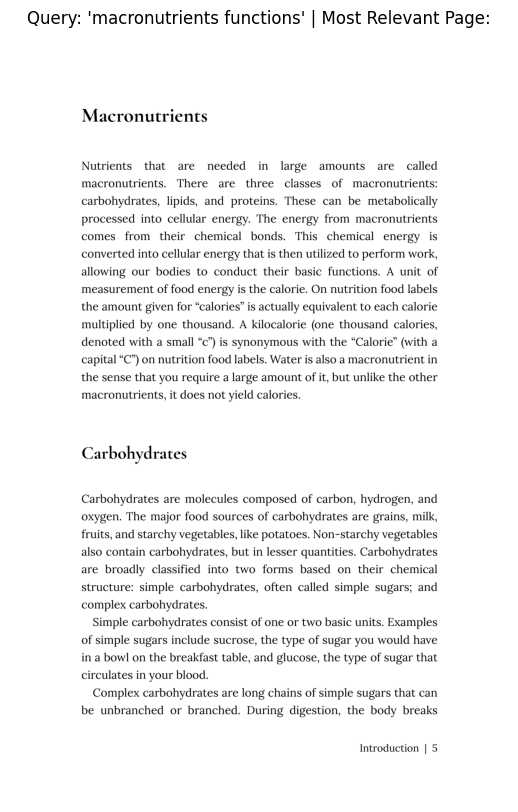

In [ ]:
import fitz as pymupdf
import matplotlib.pyplot as plt

# Load the PDF and access a specific page (adjusted for actual page number)
doc_path = "human-nutrition-text.pdf"
pdf_doc = pymupdf.open(doc_path)
target_page = pdf_doc.load_page(5 + 41)  # Our document starts on page 42

# Render the page as an image
page_image = target_page.get_pixmap(dpi=300)
pdf_doc.close()

# Convert rendered page to a NumPy array
image_array = np.frombuffer(page_image.samples_mv, dtype=np.uint8).reshape(
    (page_image.h, page_image.w, page_image.n)
)

# Display the image using matplotlib
plt.figure(figsize=(13, 10))
plt.imshow(image_array)
plt.title(f"Query: '{search_query}' | Most Relevant Page:")
plt.axis("off")
plt.show()


You’ll see the visual preview of a selected page in the nutrition PDF, useful for visually cross-referencing results.


## Step 35: Define Similarity Functions
We create two functions — one for dot product and one for cosine similarity — to measure how similar two vectors are.


In [ ]:
import torch

def compute_dot_product(vec_a, vec_b):
    """
    Computes the dot product of two vectors.
    """
    return torch.dot(vec_a, vec_b)

def compute_cosine_similarity(vec_a, vec_b):
    """
    Calculates cosine similarity between two vectors.
    """
    numerator = torch.dot(vec_a, vec_b)
    norm_a = torch.linalg.norm(vec_a)
    norm_b = torch.linalg.norm(vec_b)
    return numerator / (norm_a * norm_b)

# Sample vectors for testing
a = torch.tensor([1, 2, 3], dtype=torch.float32)
b = torch.tensor([1, 2, 3], dtype=torch.float32)
c = torch.tensor([4, 5, 6], dtype=torch.float32)
d = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Compute and print dot products
print("Dot product (a · b):", compute_dot_product(a, b))
print("Dot product (a · c):", compute_dot_product(a, c))
print("Dot product (a · d):", compute_dot_product(a, d))

# Compute and print cosine similarities
print("Cosine similarity (a, b):", compute_cosine_similarity(a, b))
print("Cosine similarity (a, c):", compute_cosine_similarity(a, c))
print("Cosine similarity (a, d):", compute_cosine_similarity(a, d))


Dot product (a · b): tensor(14.)
Dot product (a · c): tensor(32.)
Dot product (a · d): tensor(-14.)
Cosine similarity (a, b): tensor(1.0000)
Cosine similarity (a, c): tensor(0.9746)
Cosine similarity (a, d): tensor(-1.0000)


These functions will be used later to compare query vectors with text embeddings for retrieval.


## Step 36: Retrieve Top Matching Chunks
We define a search function that finds the top K most similar text chunks to a user query based on cosine similarity.


In [ ]:
def get_top_similar_chunks(
    user_query: str,
    embedding_tensor: torch.Tensor,
    model: SentenceTransformer = text_embedding_model,
    top_k: int = 5,
    show_time: bool = True
):
    """
    Embeds a user query and returns top-k most similar entries from a set of embeddings.

    Args:
        user_query (str): The text query to compare.
        embedding_tensor (torch.Tensor): Tensor of stored text embeddings.
        model (SentenceTransformer): Embedding model to use.
        top_k (int): Number of results to return.
        show_time (bool): Whether to print out the retrieval time.

    Returns:
        Tuple[Tensor, Tensor]: (similarity scores, corresponding indices)
    """
    query_vec = model.encode(user_query, convert_to_tensor=True)

    start = timer()
    similarity_scores = util.dot_score(query_vec, embedding_tensor)[0]
    end = timer()

    if show_time:
        print(f"[INFO] Scoring {len(embedding_tensor)} entries took {end - start:.5f} seconds.")

    top_scores, top_indices = torch.topk(similarity_scores, k=top_k)
    return top_scores, top_indices


def display_query_matches(
    user_query: str,
    embedding_tensor: torch.Tensor,
    reference_data: list[dict] = flattened_chunks,
    top_k: int = 5
):
    """
    Retrieves and prints the top-k relevant text chunks for a query.

    Args:
        user_query (str): The input query string.
        embedding_tensor (torch.Tensor): Embeddings to search over.
        reference_data (list[dict]): Text and metadata entries.
        top_k (int): Number of results to display.
    """
    scores, indices = get_top_similar_chunks(
        user_query,
        embedding_tensor,
        top_k=top_k
    )

    print(f"Query: {user_query}\n")
    print("Top Matches:")
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        display_wrapped_text(reference_data[idx]["text_chunk"])
        print(f"Page Number: {reference_data[idx]['adjusted_page_id']}")
        print()


No output here, but the function is now available to retrieve and rank chunks based on similarity.


## Step 37: Test Query Search
We input a query (e.g., “symptoms of pellagra”) and run our similarity search function to retrieve relevant chunks.


In [ ]:
query_text = "symptoms of pellagra"

# Retrieve similarity scores and matching indices
scores, indices = get_top_similar_chunks(
    user_query=query_text,
    embedding_tensor=embedding_tensor
)

scores, indices


[INFO] Scoring 1680 entries took 0.00009 seconds.


(tensor([0.5000, 0.3741, 0.2959, 0.2793, 0.2721], device='cuda:0'),
 tensor([ 822,  853, 1536, 1555, 1531], device='cuda:0'))

You’ll see a list of similarity scores and the indices of top-matching chunks.


## Step 38: Show Matches for User Query
We print the best-matching text chunks for the user’s query using our earlier display function.


In [ ]:
# Display top-matching text chunks for the query
display_query_matches(
    user_query=query_text,
    embedding_tensor=embedding_tensor
)


[INFO] Scoring 1680 entries took 0.00008 seconds.
Query: symptoms of pellagra

Top Matches:
Score: 0.5000
Niacin deficiency is commonly known as pellagra and the symptoms include
fatigue, decreased appetite, and indigestion.  These symptoms are then commonly
followed by the four D’s: diarrhea, dermatitis, dementia, and sometimes death.
Figure 9.12  Conversion of Tryptophan to Niacin Water-Soluble Vitamins | 565
Page Number: 565

Score: 0.3741
car. Does it drive faster with a half-tank of gas or a full one?It does not
matter; the car drives just as fast as long as it has gas. Similarly, depletion
of B vitamins will cause problems in energy metabolism, but having more than is
required to run metabolism does not speed it up. Buyers of B-vitamin supplements
beware; B vitamins are not stored in the body and all excess will be flushed
down the toilet along with the extra money spent. B vitamins are naturally
present in numerous foods, and many other foods are enriched with them. In the
Unite

You’ll see well-formatted, relevant content chunks that best match the user’s question.


## Step 39: Check Available GPU Memory
We check how much memory the GPU has. This is useful for selecting an appropriate large language model (LLM).


In [ ]:
import torch

# Retrieve total available GPU memory in bytes and convert to GB
total_gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
total_gpu_memory_gb = round(total_gpu_memory_bytes / (1024 ** 3))

print(f"Available GPU Memory: {total_gpu_memory_gb} GB")


Available GPU Memory: 15 GB


You’ll see how many GB of memory your GPU has — which helps determine whether a smaller or larger LLM can be loaded.


## Step 40: Select Model According to GPU
Depending on available GPU memory, we select a suitable quantized version of the Gemma LLM.


In [ ]:
# Select appropriate Gemma model based on GPU memory
use_quant_config = None
selected_model_id = None

if total_gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {total_gpu_memory_gb}GB, which may be insufficient to run a Gemma LLM locally without quantization.")
elif total_gpu_memory_gb < 8.1:
    print(f"GPU Memory: {total_gpu_memory_gb} GB | Recommended: Gemma 2B with 4-bit quantization.")
    use_quant_config = True
    selected_model_id = "google/gemma-2b-it"
elif total_gpu_memory_gb < 19.0:
    print(f"GPU Memory: {total_gpu_memory_gb} GB | Recommended: Gemma 2B (float16) or Gemma 7B (4-bit).")
    use_quant_config = False
    selected_model_id = "google/gemma-2b-it"
else:
    print(f"GPU Memory: {total_gpu_memory_gb} GB | Recommended: Gemma 7B in float16 or 4-bit mode.")
    use_quant_config = False
    selected_model_id = "google/gemma-7b-it"

print(f"use_quant_config set to: {use_quant_config}")
print(f"selected_model_id set to: {selected_model_id}")


GPU Memory: 15 GB | Recommended: Gemma 2B (float16) or Gemma 7B (4-bit).
use_quant_config set to: False
selected_model_id set to: google/gemma-2b-it


This prints the selected model variant. For lower memory (e.g., under 5 GB), a smaller 2-bit model may be chosen.


## Step 41: Log Into Hugging Face
To download and use private or gated LLMs from Hugging Face, we log in securely using an access token.


In [ ]:
from huggingface_hub import login
from getpass import getpass

# Prompt user securely for Hugging Face token
hf_token = getpass("Enter your Hugging Face token: ")
login(token=hf_token)


Enter your Hugging Face token: ··········


You’ll be prompted to enter your Hugging Face token. Once successful, it enables access to gated models.


## Step 42: Load the Gemma LLM
We now load the Gemma large language model using Transformers. Depending on GPU memory, this could include quantized versions for efficiency.


In [ ]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)
from transformers.utils import is_flash_attn_2_available

# Step 1: Optional quantization config for low-memory setups
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

# Step 2: Determine attention mechanism
if is_flash_attn_2_available() and torch.cuda.get_device_capability(0)[0] >= 8:
    attention_type = "flash_attention_2"
else:
    attention_type = "sdpa"
print(f"[INFO] Attention type set to: {attention_type}")

# Step 3: Use pre-selected model ID and quant config decision
print(f"[INFO] Loading model: {selected_model_id}")

# Step 4: Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=selected_model_id)

# Step 5: Load the language model with appropriate configuration
llm_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=selected_model_id,
    torch_dtype=torch.float16,
    quantization_config=quant_config if use_quant_config else None,
    low_cpu_mem_usage=False,
    attn_implementation=attention_type
)

# If not using quantization, move model manually to GPU
if not use_quant_config:
    llm_model.to("cuda")


[INFO] Attention type set to: sdpa
[INFO] Loading model: google/gemma-2b-it


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

The model is now loaded into memory and ready for inference. No output unless there's a loading error.


## Step 43: Display Model Summary
We display summary info about the loaded LLM to confirm it loaded correctly and see its details.


In [ ]:
# Display summary info about the loaded LLM model
llm_model


GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): GemmaRMSNorm((2048,), 

You’ll see the model object with architecture details, layer count, and device info (CPU/GPU).


## Step 44: Count Total Parameters in the Model
This function computes and prints the total number of trainable and non-trainable parameters in the loaded model.


In [ ]:
def count_model_parameters(model: torch.nn.Module) -> int:
    """
    Returns the total number of parameters in a PyTorch model.

    Args:
        model (torch.nn.Module): The model to inspect.

    Returns:
        int: Total number of parameters.
    """
    return sum(param.numel() for param in model.parameters())

# Get total parameter count of the loaded LLM
count_model_parameters(llm_model)


2506172416

The total parameter count is printed — helpful for understanding model complexity and size.


## Step 45: Estimate Model Memory Usage
This helper function estimates how much memory the model uses in bytes, megabytes, and gigabytes.


In [ ]:
def calculate_model_memory_usage(model: torch.nn.Module) -> dict:
    """
    Estimates the memory usage of a PyTorch model in bytes, MB, and GB.

    Returns:
        dict: Dictionary containing memory sizes in bytes, MB, and GB.
    """
    param_memory = sum(p.nelement() * p.element_size() for p in model.parameters())
    buffer_memory = sum(b.nelement() * b.element_size() for b in model.buffers())

    total_bytes = param_memory + buffer_memory
    return {
        "memory_bytes": total_bytes,
        "memory_mb": round(total_bytes / (1024 ** 2), 2),
        "memory_gb": round(total_bytes / (1024 ** 3), 2)
    }

# Calculate and return memory stats for the current model
calculate_model_memory_usage(llm_model)


{'memory_bytes': 5012345344, 'memory_mb': 4780.15, 'memory_gb': 4.67}

The output is a dictionary showing memory use — very useful for deployment and optimization planning.


## Step 46: Format an Instructional Prompt
We build a conversational prompt (instruction + user query) to send to the LLM for generating a response.


In [ ]:
# Define the input query
user_input = "What are the macronutrients, and what roles do they play in the human body?"
print(f"Input Text:\n{user_input}")

# Construct conversation template for instruction-tuned LLM
chat_format = [
    {"role": "user", "content": user_input}
]

# Generate raw prompt using the tokenizer's chat template
formatted_prompt = tokenizer.apply_chat_template(
    conversation=chat_format,
    tokenize=False,
    add_generation_prompt=True
)

print(f"\nFormatted Prompt:\n{formatted_prompt}")


Input Text:
What are the macronutrients, and what roles do they play in the human body?

Formatted Prompt:
<bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model



You’ll see the complete input prompt that will be tokenized and used for model inference.


## Step 47: Generate an Answer From the LLM
We tokenize the input and generate a response using the model. This is the core inference step.


In [ ]:
%%time

# Tokenize the formatted prompt and move input to GPU
encoded_input = tokenizer(formatted_prompt, return_tensors="pt").to("cuda")
print(f"Tokenized Input:\n{encoded_input}\n")

# Generate a response using the model
# Adjust max_new_tokens as needed for longer or shorter replies
generated_output = llm_model.generate(
    **encoded_input,
    max_new_tokens=256
)

print(f"Generated Output Tokens:\n{generated_output[0]}\n")


Tokenized Input:
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
         184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
            573,   3515,   2971, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}

Generated Output Tokens:
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
           573,   3515,   2971, 235336,    107,    108,    106,   2516,    108,
         21404, 235269,   1517, 235303, 235256,    476,  25497,    576,    573,
        186809, 184592,    578,   1024,  16065,    575,    573,   3515,   2971,
        235292,    109,    688,  12298,   1695, 184592,  66058,    109, 235287,
          5231, 156615,  56227,  66058,    108,    141, 

You’ll see the raw output tensor, which is the LLM’s predicted token sequence.


## Step 48: Convert Tokens Back to Text
We decode the generated output from tokens into human-readable text.


In [ ]:
# Convert the generated tokens back into human-readable text
decoded_response = tokenizer.decode(generated_output[0])
print(f"Model Output (Decoded):\n{decoded_response}\n")


Model Output (Decoded):
<bos><bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of the macronutrients and their roles in the human body:

**Macronutrients:**

* **Carbohydrates:**
    * Provide energy for the body's cells and tissues.
    * Carbohydrates are the primary source of energy for most cells.
    * Complex carbohydrates are those that take longer to digest, such as whole grains, fruits, and vegetables.
    * Simple carbohydrates are those that are quickly digested, such as sugar, starch, and lactose.

* **Proteins:**
    * Build and repair tissues, enzymes, and hormones.
    * Proteins are essential for immune function, hormone production, and tissue repair.
    * There are different types of proteins, each with specific functions.

* **Fats:**
    * Provide energy, insulation, and help absorb vitamins.
    * Healthy fats include olive oil, avocado, nuts, and seeds.
  

You’ll see the model’s full decoded output — including the question and generated answer.


## Step 49: Display Final Response Without Prompt
To make the output cleaner, we strip out the prompt portion and display just the model’s response.


In [ ]:
# Display the original input and the model's trimmed response
print(f"Input Text:\n{user_input}\n")
print("Model Response:")
print(decoded_response.replace(formatted_prompt, "").replace("<bos>", "").replace("<eos>", "").strip())


Input Text:
What are the macronutrients, and what roles do they play in the human body?

Model Response:
Sure, here's a breakdown of the macronutrients and their roles in the human body:

**Macronutrients:**

* **Carbohydrates:**
    * Provide energy for the body's cells and tissues.
    * Carbohydrates are the primary source of energy for most cells.
    * Complex carbohydrates are those that take longer to digest, such as whole grains, fruits, and vegetables.
    * Simple carbohydrates are those that are quickly digested, such as sugar, starch, and lactose.

* **Proteins:**
    * Build and repair tissues, enzymes, and hormones.
    * Proteins are essential for immune function, hormone production, and tissue repair.
    * There are different types of proteins, each with specific functions.

* **Fats:**
    * Provide energy, insulation, and help absorb vitamins.
    * Healthy fats include olive oil, avocado, nuts, and seeds.
    * Trans fats can raise cholesterol levels and increase th

Only the final answer is shown here, without repeating the input prompt. This is cleaner for presentation.


## Step 50: Use Sample AI-Generated Questions
We load a list of nutrition-related questions that were previously generated by GPT-4 to test the system.


In [ ]:
# Nutrition-related questions generated by GPT-4
ai_generated_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually crafted questions for evaluation
human_written_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

# Combine all questions into a single list
all_queries = ai_generated_questions + human_written_questions


This defines a list of questions (not shown in output), which will be used in search and query testing.


## Step 51: Pick a Random Query for Testing
We randomly choose one question from the pre-defined list. This simulates a user asking a natural question.


In [ ]:
import random as rnd

# Randomly select a query from the combined list
random_query = rnd.choice(all_queries)
print(f"Selected Query:\n{random_query}")

# Retrieve top matching scores and indices for the selected query
scores, indices = get_top_similar_chunks(
    user_query=random_query,
    embedding_tensor=embedding_tensor
)

scores, indices


Selected Query:
What are symptoms of pellagra?
[INFO] Scoring 1680 entries took 0.00011 seconds.


(tensor([0.4712, 0.3562, 0.3153, 0.3025, 0.2941], device='cuda:0'),
 tensor([ 822,  853, 1536, 1555, 1531], device='cuda:0'))

You’ll see a randomly selected question printed — it will be used as the query for the next steps.


## Step 52: Build a Prompt With Relevant Context
We define a function to construct a rich prompt. It combines the selected question with the top-matching context chunks from our dataset.


In [ ]:
def build_contextual_prompt(query: str, context_items: list[dict]) -> str:
    """
    Constructs a rich prompt by combining example answers with relevant context snippets
    for use with instruction-tuned LLMs.

    Args:
        query (str): The user's input question.
        context_items (list[dict]): List of context items containing sentence chunks.

    Returns:
        str: Fully formatted prompt string ready for model inference.
    """
    # Join context snippets into bullet points
    context_block = "- " + "\n- ".join(item["text_chunk"] for item in context_items)

    # Reference examples to guide model output style
    examples = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.

Example 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.

Example 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.

Now use the following context items to answer the user query:
{context}

Relevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Fill in context and user query
    full_prompt_text = examples.format(context=context_block, query=query)

    # Wrap in a chat-style prompt format
    chat_input = [{"role": "user", "content": full_prompt_text}]
    model_prompt = tokenizer.apply_chat_template(
        conversation=chat_input,
        tokenize=False,
        add_generation_prompt=True
    )

    return model_prompt


No output yet — this function will generate custom prompts for the LLM using relevant text chunks.


## Step 53: Retrieve Matching Context for Query
We perform a similarity search using the selected query to find the most relevant chunks from the embedded dataset.


In [ ]:
import random as rnd

# Randomly select a query from the list
selected_query = rnd.choice(all_queries)
print(f"Query: {selected_query}")

# Retrieve top-matching context items based on similarity
scores, indices = get_top_similar_chunks(
    user_query=selected_query,
    embedding_tensor=embedding_tensor
)

# Extract matching context chunks
matched_context = [flattened_chunks[i] for i in indices]

# Build the full prompt with embedded examples and context
formatted_prompt = build_contextual_prompt(
    query=selected_query,
    context_items=matched_context
)

# Display the constructed prompt
print(formatted_prompt)


Query: What role does fibre play in digestion? Name five fibre containing foods.
[INFO] Scoring 1680 entries took 0.00012 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for bl

The printed output shows the query and its top-matching context chunks, which will be fed into the LLM.


## Step 54: Generate an Answer Using Retrieved Context
We format the prompt with the selected question and relevant context, then send it to the LLM for response generation.


In [ ]:
%%time

# Tokenize the formatted prompt and move it to GPU
encoded_input = tokenizer(formatted_prompt, return_tensors="pt").to("cuda")

# Generate response from the model
generated_tokens = llm_model.generate(
    **encoded_input,
    temperature=0.7,         # Controls randomness of output
    do_sample=True,          # Enable sampling for diverse answers
    max_new_tokens=256       # Limit length of generated response
)

# Decode tokens to readable text
response_text = tokenizer.decode(generated_tokens[0])

# Display the results
print(f"Query: {selected_query}")
print("RAG Answer:")
print(response_text.replace(formatted_prompt, "").strip())


Query: What role does fibre play in digestion? Name five fibre containing foods.
RAG Answer:
<bos>The passage mentions that dietary fiber is categorized into two groups: soluble and insoluble. Soluble fibers are more easily broken down by bacterial enzymes in the large intestine, while insoluble fibers are digested much less. The passage also mentions that consuming foods high in fiber can reduce the rise in blood glucose after eating them, and that this can contribute to weight loss and a decreased risk of chronic diseases.

Five fiber-containing foods are mentioned in the context:
- Whole grains
- Vegetables
- Fruits
- Beans
- Legumes<eos>
CPU times: user 3.8 s, sys: 17.1 ms, total: 3.82 s
Wall time: 3.96 s


The model will generate a detailed answer based on both the question and the contextual chunks. This is a full retrieval-augmented generation step.


## Step 55: Create a Question-Answering Function
We define a function that handles the complete process: from query input to context retrieval and final LLM answer generation.


In [ ]:
def ask_question(
    query: str,
    temperature: float = 0.7,
    max_new_tokens: int = 512,
    format_answer_text: bool = True,
    return_answer_only: bool = True
):
    """
    Retrieves relevant context and generates an answer to a given query using RAG.

    Args:
        query (str): The user query.
        temperature (float): Controls randomness in generation.
        max_new_tokens (int): Max number of tokens to generate.
        format_answer_text (bool): Whether to clean and trim the model output.
        return_answer_only (bool): If True, returns only the answer. Otherwise, also returns context.

    Returns:
        str or (str, list[dict]): The generated answer, optionally with context items used.
    """
    # Step 1: Retrieve relevant context
    scores, indices = get_top_similar_chunks(query, embedding_tensor)

    # Step 2: Build context item list with scores
    context_snippets = [flattened_chunks[i] for i in indices]
    for idx, snippet in enumerate(context_snippets):
        snippet["score"] = scores[idx].cpu()

    # Step 3: Format prompt with embedded context
    formatted_prompt = build_contextual_prompt(query=query, context_items=context_snippets)

    # Step 4: Tokenize input and run model generation
    encoded_prompt = tokenizer(formatted_prompt, return_tensors="pt").to("cuda")
    generated = llm_model.generate(
        **encoded_prompt,
        temperature=temperature,
        do_sample=True,
        max_new_tokens=max_new_tokens
    )

    # Step 5: Decode and optionally clean up output
    decoded_output = tokenizer.decode(generated[0])
    if format_answer_text:
        decoded_output = (
            decoded_output
            .replace(formatted_prompt, "")
            .replace("<bos>", "")
            .replace("<eos>", "")
            .replace("Sure, here is the answer to the user query:\n\n", "")
            .strip()
        )

    if return_answer_only:
        return decoded_output
    else:
        return decoded_output, context_snippets


No output here, but this function streamlines the end-to-end flow for answering any query using your data and the LLM.


## Step 56: Run a Full Q&A Demo
We pick a question, retrieve matching context, and generate an answer using the LLM — all using the function we just defined.


In [ ]:
import random as rnd

# Select a random query
selected_query = rnd.choice(all_queries)
print(f"Query: {selected_query}")

# Generate answer along with supporting context
answer_text, supporting_context = ask_question(
    query=selected_query,
    temperature=0.7,
    max_new_tokens=512,
    return_answer_only=False
)

# Display the generated answer
print("\nAnswer:\n")
display_wrapped_text(answer_text)

# Show the context items used
print("\nContext Items Used:")
supporting_context


Query: What are the macronutrients, and what roles do they play in the human body?
[INFO] Scoring 1680 entries took 0.00010 seconds.

Answer:

Sure, here's the answer to the user's query:  The context provides a
comprehensive overview of macronutrients, including carbohydrates, lipids, and
proteins, and their crucial roles in the human body.  **Carbohydrates** provide
the body with energy, serve as building blocks for cells, and are essential for
tissue formation, cell repair, and hormone and enzyme production. They are the
body's main source of energy and are crucial for maintaining overall health and
well-being.  **Lipids** provide stored energy, function as structural components
of cells, and are important for hormone production. They help to regulate body
temperature and can assist in the absorption of fat-soluble vitamins.
**Proteins** are essential for tissue formation, cell repair, and hormone and
enzyme production. They help build and repair muscle, and can also help to
produce

[{'adjusted_page_id': 5,
  'text_chunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of 

The printed output includes the original question, relevant context, and the final generated answer.
